<a href="https://colab.research.google.com/github/yakuparas28/YuksekLisans/blob/main/YapaySinirAglariFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Gerekli kütüphaneleri yükleme
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import DenseNet121, MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\yakup\.cache\kagglehub\datasets\omkargurav\face-mask-dataset\versions\1


In [ ]:
import os

# Çalışma dizinini öğrenmek
current_directory = os.getcwd()
print(f"Current Directory: {current_directory}")

# Yeni bir dizin oluşturmak
os.mkdir("dataset")

Current Directory: C:\Users\yakup


In [ ]:
import shutil
import os

# Kaynak ve hedef dizinleri belirliyoruz
source_dir = ".cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/data"
destination_dir = "dataset/"

# Hedef dizin yoksa oluşturun
os.makedirs(destination_dir, exist_ok=True)

# Kaynak dizindeki tüm dosyaları ve alt dizinleri hedef dizine kopyalayın
try:
    shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)
    print(f"Veriler başarıyla '{destination_dir}' dizinine kopyalandı.")
except Exception as e:
    print(f"Kopyalama sırasında bir hata oluştu: {e}")

Veriler başarıyla 'dataset/' dizinine kopyalandı.


In [ ]:
# Veri seti yolunu belirleme
dataset_dir = "dataset"  # Veri seti klasörünün yolunu belirtin (klasörün bulunduğu yer).

# Eğitim ve test ayrımı için ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2  # %20 validasyon seti
)

# Eğitim verisi
train_data = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

# Validasyon verisi
val_data = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

# Test verisi için aynı veri setini kullanabiliriz (opsiyonel)
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_data = test_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.
Found 7553 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Modelin temelini oluştur
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Özel katmanlar ekleme
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global ortalama havuzlama
x = Dropout(0.5)(x)  # Dropout (aşırı öğrenmeyi önlemek için)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # 2 sınıf için çıkış katmanı

# Modeli oluştur
model = Model(inputs=base_model.input, outputs=predictions)

# Bazı katmanları dondurma (base modeldeki eğitilmiş ağırlıkları korumak için)
for layer in base_model.layers:
    layer.trainable = False

# Modeli derleme
model.compile(
    optimizer=Adam(learning_rate=0.001),  # ADAM optimizer
    loss='categorical_crossentropy',  # Kategorik çapraz entropi kaybı
    metrics=['accuracy']  # Doğruluk metriği
)

# Modelin özetini görüntüle
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,333,058 (27.97 MB)

 Trainable params: 295,554 (1.13 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping ve öğrenme hızı azaltma
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Modeli eğitme
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

C:\Users\yakup\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
118/189 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - accuracy: 0.9246 - loss: 0.1671

C:\ProgramData\anaconda3\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 482s 2s/step - accuracy: 0.9408 - loss: 0.1358 - val_accuracy: 0.9921 - val_loss: 0.0239 - learning_rate: 0.0010
Epoch 2/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 437s 2s/step - accuracy: 0.9825 - loss: 0.0554 - val_accuracy: 0.9914 - val_loss: 0.0247 - learning_rate: 0.0010
Epoch 3/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - accuracy: 0.9854 - loss: 0.0481 - val_accuracy: 0.9894 - val_loss: 0.0269 - learning_rate: 0.0010
Epoch 4/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.9832 - loss: 0.0497 - val_accuracy: 0.9921 - val_loss: 0.0214 - learning_rate: 0.0010
Epoch 5/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - accuracy: 0.9845 - loss: 0.0422 - val_accuracy: 0.9901 - val_loss: 0.0336 - learning_rate: 0.0010
Epoch 6/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.9823 - loss: 0.0462 - val_accuracy: 0.9947 - val_loss: 0.0197 - learning_rate: 0.0010
Epoch 7/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.9916 - loss: 0.0315 

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Test set üzerinde tahminler yap
y_pred_probs = model.predict(test_data)  # Olasılık tahminleri
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Sınıf tahminleri
y_true = test_data.classes  # Gerçek sınıflar

# 1. **Confusion Matrix (Karışıklık Matrisi)**
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

237/237 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step
Confusion Matrix:
[[1844 1881]
 [1881 1947]]


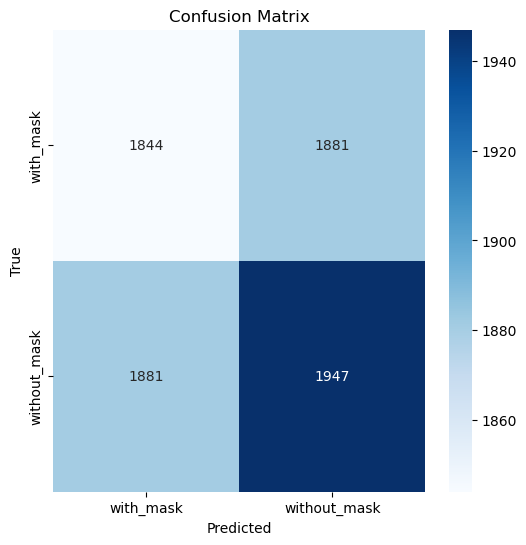

In [ ]:
# Görselleştirme
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Test set üzerinde tahminler yap
y_pred_probs = model.predict(test_data)  # Olasılık tahminleri
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Sınıf tahminleri
y_true = test_data.classes  # Gerçek sınıflar

# 1. **Confusion Matrix (Karışıklık Matrisi)**
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)




237/237 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step
Confusion Matrix:
[[1847 1878]
 [1878 1950]]


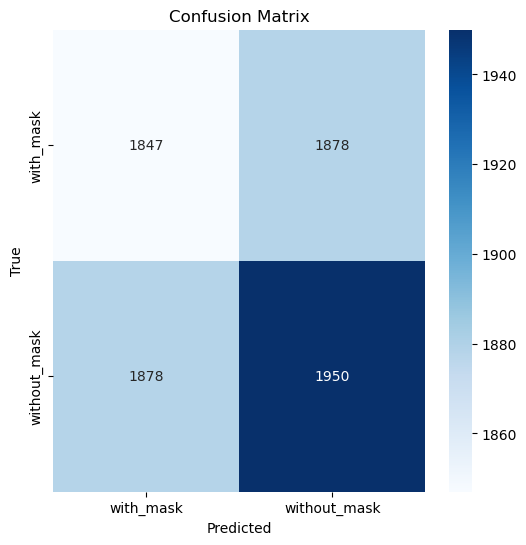

In [ ]:
# Görselleştirme
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# 2. **Classification Report (Doğruluk, Precision, Recall, F1-Score)**
class_report = classification_report(y_true, y_pred_classes, target_names=test_data.class_indices.keys())
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

   with_mask       0.50      0.50      0.50      3725
without_mask       0.51      0.51      0.51      3828

    accuracy                           0.50      7553
   macro avg       0.50      0.50      0.50      7553
weighted avg       0.50      0.50      0.50      7553



In [ ]:
# 3. **ROC Curve ve AUC Skoru**
# Gerçek sınıflar için one-hot encoding
from sklearn.preprocessing import label_binarize
n_classes = len(test_data.class_indices)
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# ROC eğrisi için her sınıfın olasılık tahminleri
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC eğrisini çizme
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {list(test_data.class_indices.keys())[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
print("y_pred_probs.shape:", y_pred_probs.shape)
print("y_true_bin.shape:", y_true_bin.shape)
print("n_classes:", n_classes)

y_pred_probs.shape: (7553, 2)
y_true_bin.shape: (7553, 1)
n_classes: 2


In [ ]:
from sklearn.preprocessing import label_binarize

# Gerçek sınıfları 2 sınıfa genişletin (0 ve 1 sınıfları)
y_true_bin = label_binarize(y_true, classes=[0, 1])  # 0: with_mask, 1: without_mask

print("y_true_bin.shape:", y_true_bin.shape)  # Beklenen: (7553, 2)

y_true_bin.shape: (7553, 1)


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC eğrisi ve AUC için sözlükler
fpr = {}
tpr = {}
roc_auc = {}

# Her sınıf için ROC eğrisi ve AUC hesaplama
for i in range(2):  # 2 sınıf için döngü
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC eğrisini görselleştirme
plt.figure(figsize=(8, 6))
for i in range(2):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title("ROC Curve")
plt.show()


IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
print("y_true sınıfları:", np.unique(y_true))

y_true sınıfları: [0 1]


In [ ]:
# y_true dizisini iki sınıfa genişletme (manuel one-hot encoding)
y_true_bin = np.zeros((y_true.shape[0], 2))  # 2 sınıf için bir matris oluştur
y_true_bin[np.arange(y_true.shape[0]), y_true] = 1  # Doğru sınıfın sütununu 1 yap

print("y_true_bin.shape:", y_true_bin.shape)  # Beklenen: (7553, 2)

y_true_bin.shape: (7553, 2)


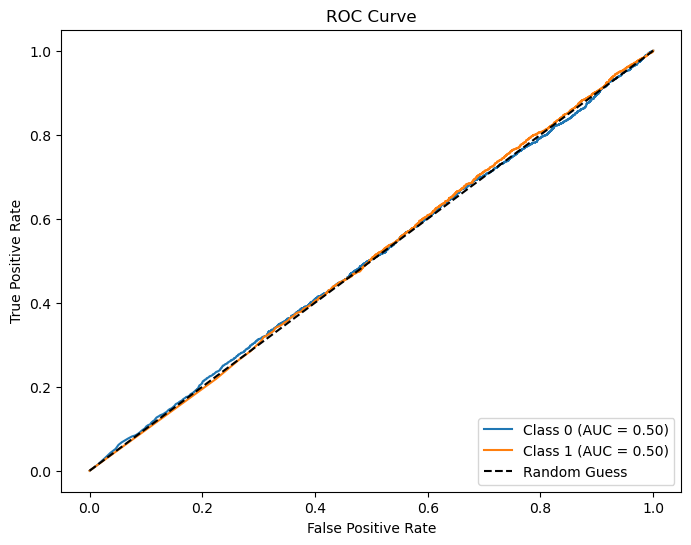

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = {}
tpr = {}
roc_auc = {}

# Her sınıf için ROC eğrisi ve AUC hesaplama
for i in range(2):  # 2 sınıf için (0 ve 1)
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC eğrisini çizme
plt.figure(figsize=(8, 6))
for i in range(2):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title("ROC Curve")
plt.show()
